In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(555)

### **数据处理**
#### 本实验选择数据集为MovieLens-1M数据集，其中80%作为训练集，20%作为测试集
#### 并分别对训练数据和测试数据进行用户-电影交互矩阵的构建

In [2]:
class DataProcess:
    def __init__(self, data_path, alpha=0.8):
        print("start load data")
        df=pd.read_csv(data_path,sep="::",names=['uid', 'iid', 'ratings','time'],encoding='utf-8')
        print("start process data")
        df.drop('time',axis=1)
        #
        self.n_user = max(df['uid'].values)
        self.n_item = max(df['iid'].values)
        
        self.data = df[['uid', 'iid', 'ratings']].values
        self.train_mx = np.zeros((self.n_user, self.n_item))
        self.test_mx = np.zeros((self.n_user, self.n_item))
        
        for u,i,r in self.data:
            if (np.random.random() < alpha):
                self.train_mx[u-1][i-1] = r
            else:
                self.test_mx[u-1][i-1] = r 

### **构造评估函数**
#### 使用MAE和RMSE对预测结果进行评估。

In [3]:
# MAE
def MAE(mx,u,v):
    I=mx.copy()
    I[I>0]=1
    return np.sum(np.fabs(I * (mx - np.dot(u.T,v))))/len(mx[mx > 0])
# RMSE
def RMSE(mx,u,v):
    I=mx.copy()
    I[I>0]=1
    return np.sqrt(np.sum((I * (mx - np.dot(u.T,v)))**2)/len(mx[mx > 0]))

### **ALS矩阵分解**
#### 使用ALS方法实现矩阵分解。

In [4]:
class ALS_MF():
    def __init__(self, train_mx, test_mx, k=20, beta=0.1, iterations = 15):      
        # training and test matrix
        self.train_mx = train_mx 
        self.test_mx = test_mx
        self.m = train_mx.shape[0]
        self.n = train_mx.shape[1]
        self.k = k
        self.beta = beta 
        self.iterations=iterations
        self.train_mae_list = []
        self.train_rmse_list = []
        self.test_mae_list = []
        self.test_rmse_list = []
        self.u=np.zeros((self.k, self.m))
        self.v=np.zeros((self.k, self.n))
    
    def train(self):
        print("start train")
        u = np.random.rand(self.k, self.m) 
        v = np.random.rand(self.k, self.n) 
        v[0,:] = self.train_mx[self.train_mx>0].mean(axis=0)
        I = np.eye(self.k)

        for iteration in range(self.iterations):
            # 固定v预测u
            for i in range(self.m):
                nonzero_list=np.nonzero(self.train_mx[i])[0]
                num = max(len(nonzero_list),1)
                v_nonzero = v[:, nonzero_list]
                line = self.train_mx[i, nonzero_list]
                A = np.dot(v_nonzero, v_nonzero.T) + self.beta * num * I
                B = np.dot(v_nonzero, line.T)
                u[:, i] = np.linalg.solve(A, B)
            
            # 固定u预测v
            for i in range(self.n):
                nonzero_list=np.nonzero(self.train_mx.T[i])[0]
                num = max(len(nonzero_list),1)
                u_nonzero = u[:, nonzero_list]
                line = self.train_mx.T[i, nonzero_list]
                A = np.dot(u_nonzero, u_nonzero.T) + self.beta * num * I
                B = np.dot(u_nonzero, line.T)
                v[:, i] = np.linalg.solve(A, B)
            
            train_mae=MAE(self.train_mx, u, v)
            train_rmse=RMSE(self.train_mx, u, v)
            test_mae=MAE(self.test_mx, u, v)
            test_rmse=RMSE(self.test_mx, u, v)
            
            self.train_mae_list.append(train_mae)
            self.train_rmse_list.append(train_rmse)
            self.test_mae_list.append(test_mae)
            self.test_rmse_list.append(test_rmse)
            
            print("[Iteration {}/{}] train mae: {:.4f}|train rmse: {:.4f}|test mae: {:.4f}|test rmse: {:.4f}"
                  .format(iteration+1,self.iterations,train_mae,train_rmse,test_mae,test_rmse))
        self.u=u
        self.v=v
            
    def evaluate(self):
        test_mae=MAE(self.test_mx, self.u, self.v)
        test_rmse=RMSE(self.test_mx, self.u, self.v)
        print("mae :{} rmse :{}".format(test_mae,test_rmse))

### **训练模型**
#### 训练模型，并对模型预测结果进行评估

In [5]:
dp = DataProcess("../input/movielens-1m-dataset/ratings.dat")
md = ALS_MF(dp.train_mx, dp.test_mx)
md.train()
md.evaluate()

start load data


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


start process data
start train
[Iteration 1/15] train mae: 0.8124|train rmse: 0.9890|test mae: 0.8422|test rmse: 1.0250
[Iteration 2/15] train mae: 0.7438|train rmse: 0.9079|test mae: 0.7747|test rmse: 0.9474
[Iteration 3/15] train mae: 0.7018|train rmse: 0.8619|test mae: 0.7394|test rmse: 0.9106
[Iteration 4/15] train mae: 0.6819|train rmse: 0.8404|test mae: 0.7228|test rmse: 0.8938
[Iteration 5/15] train mae: 0.6697|train rmse: 0.8275|test mae: 0.7129|test rmse: 0.8840
[Iteration 6/15] train mae: 0.6613|train rmse: 0.8188|test mae: 0.7062|test rmse: 0.8775
[Iteration 7/15] train mae: 0.6553|train rmse: 0.8126|test mae: 0.7014|test rmse: 0.8730
[Iteration 8/15] train mae: 0.6507|train rmse: 0.8080|test mae: 0.6978|test rmse: 0.8697
[Iteration 9/15] train mae: 0.6473|train rmse: 0.8046|test mae: 0.6951|test rmse: 0.8672
[Iteration 10/15] train mae: 0.6446|train rmse: 0.8019|test mae: 0.6929|test rmse: 0.8653
[Iteration 11/15] train mae: 0.6424|train rmse: 0.7999|test mae: 0.6912|test r

### **绘制曲线**
#### 使用plt绘制模型在训练集和测试集上MAE和RMSE的下降趋势

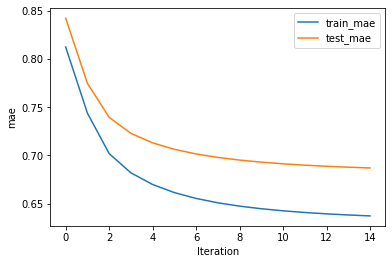

In [6]:
plt.plot(md.train_mae_list)
plt.plot(md.test_mae_list)
plt.xlabel("Iteration")
plt.ylabel("mae")
plt.legend(["train_mae","test_mae"]);

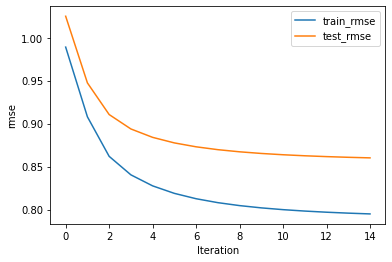

In [7]:
plt.plot(md.train_rmse_list)
plt.plot(md.test_rmse_list)
plt.xlabel("Iteration")
plt.ylabel("rmse")
plt.legend(["train_rmse","test_rmse"]);